## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [6]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [7]:
# Переводим pickup_datetime в формат datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Определяем временные рамки (без учёта времени)
min_date = taxi_data['pickup_datetime'].dt.date.min()
max_date = taxi_data['pickup_datetime'].dt.date.max()

print(f"Данные охватывают период с {min_date} по {max_date}")

Данные охватывают период с 2016-01-01 по 2016-06-30


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [8]:
# Подсчёт пропусков по всем столбцам
missing_values = taxi_data.isnull().sum().sum()

print(f"Общее количество пропущенных значений в датасете: {missing_values}")

Общее количество пропущенных значений в датасете: 0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [9]:
# а) Сколько уникальных таксопарков (vendor_id)
unique_vendors = taxi_data['vendor_id'].nunique()

# б) Максимальное количество пассажиров
max_passengers = taxi_data['passenger_count'].max()

# в) Средняя и медианная длительность поездки (округляем)
mean_duration = round(taxi_data['trip_duration'].mean())
median_duration = round(taxi_data['trip_duration'].median())

# г) Минимальное и максимальное время поездки
min_duration = taxi_data['trip_duration'].min()
max_duration = taxi_data['trip_duration'].max()

print(f"Уникальных таксопарков: {unique_vendors}")
print(f"Максимальное количество пассажиров: {max_passengers}")
print(f"Средняя длительность поездки: {mean_duration} секунд")
print(f"Медианная длительность поездки: {median_duration} секунд")
print(f"Минимальная длительность поездки: {min_duration} секунд")
print(f"Максимальная длительность поездки: {max_duration} секунд")


Уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность поездки: 959 секунд
Медианная длительность поездки: 662 секунд
Минимальная длительность поездки: 1 секунд
Максимальная длительность поездки: 3526282 секунд


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [10]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek  # Пн=0, ..., Вс=6
    return df

# Применяем функцию
taxi_data = add_datetime_features(taxi_data)

saturday_trips = (taxi_data['pickup_day_of_week'] == 5).sum()
print(f"Количество поездок в субботу: {saturday_trips}")

avg_trips_per_day = round(taxi_data.groupby('pickup_date').size().mean())
print(f"Среднее количество поездок в день: {avg_trips_per_day}")

Количество поездок в субботу: 220868
Среднее количество поездок в день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [14]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

def add_holiday_features(trips_df, holidays_df):
    # преобразуем даты в holiday_data к типу datetime.date
    holidays_df['date'] = pd.to_datetime(holidays_df['date']).dt.date
    
    # добавляем бинарный признак: 1 - праздник, 0 - нет
    trips_df['pickup_holiday'] = trips_df['pickup_date'].isin(holidays_df['date']).astype(int)
    
    return trips_df

# применяем функцию
taxi_data = add_holiday_features(taxi_data, holiday_data)

In [15]:
median_holiday_trip = round(taxi_data.loc[taxi_data['pickup_holiday'] == 1, 'trip_duration'].median())
print(f"Медианная длительность поездки в праздничные дни: {median_holiday_trip} секунд")

Медианная длительность поездки в праздничные дни: 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [16]:
osrm_data = pd.read_csv('osrm_data_train.csv')

def add_osrm_features(trips_df, osrm_df):
    # объединяем по id
    merged = trips_df.merge(osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], 
                            on='id', how='left')
    return merged

# применяем функцию
taxi_data = add_osrm_features(taxi_data, osrm_data)

# медианная длительность по нашим данным
median_trip_duration = taxi_data['trip_duration'].median()

# медианная длительность по OSRM API
median_osrm_duration = taxi_data['total_travel_time'].median()

# разница в секундах
diff_median = round(median_trip_duration - median_osrm_duration)

print(f"Разница между медианами: {diff_median} секунд")

missing_osrm = taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().sum()

print("Количество пропусков в данных OSRM:")
print(missing_osrm)

Разница между медианами: 372 секунд
Количество пропусков в данных OSRM:
total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64


In [17]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [18]:
def add_geographical_features(df):
    # расстояние Хаверсина
    df['haversine_distance'] = df.apply(lambda row: get_haversine_distance(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    
    # направление движения
    df['direction'] = df.apply(lambda row: get_angle_direction(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    
    return df

# применяем функцию
taxi_data = add_geographical_features(taxi_data)

median_haversine = round(taxi_data['haversine_distance'].median(), 2)
print(f"Медианное расстояние Хаверсина поездок: {median_haversine} км")

Медианное расстояние Хаверсина поездок: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [19]:
from sklearn import cluster
import numpy as np

def add_cluster_features(df, kmeans_model):
    # формируем признаки для предсказания кластера
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    
    # предсказываем кластеры
    df['geo_cluster'] = kmeans_model.predict(coords)
    return df

# обучаем KMeans
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# применяем функцию
taxi_data = add_cluster_features(taxi_data, kmeans)

cluster_counts = taxi_data['geo_cluster'].value_counts()
min_cluster_size = cluster_counts.min()

print(f"Количество поездок в самом маленьком географическом кластере: {min_cluster_size}")

Количество поездок в самом маленьком географическом кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [21]:
print(weather_data.columns)

Index(['time', 'temperature', 'windchill', 'heat index', 'humidity',
       'pressure', 'dew Point', 'visibility', 'wind dir', 'wind speed',
       'gust speed', 'precip', 'events', 'conditions', 'date', 'hour'],
      dtype='object')


In [25]:
weather_data = pd.read_csv('weather_data.csv')

def add_weather_features(trips_df, weather_df):
    # создаём datetime из date + hour
    weather_df['datetime'] = pd.to_datetime(weather_df['date'] + ' ' + weather_df['hour'].astype(str) + ':00:00')

    # округляем pickup_datetime до часа
    trips_df['pickup_hour_dt'] = trips_df['pickup_datetime'].dt.floor('H')

    # объединяем таблицы
    merged = trips_df.merge(weather_df, left_on='pickup_hour_dt', right_on='datetime', how='left')

    # оставляем только нужные погодные признаки и убираем суффиксы
    rename_dict = {
        'temperature': 'temperature',
        'visibility': 'visibility',
        'wind speed': 'wind_speed',
        'precip': 'precip',
        'events': 'events'
    }

    merged.rename(columns=rename_dict, inplace=True)

    return merged

# применяем функцию
taxi_data = add_weather_features(taxi_data, weather_data)

snow_trips = taxi_data['events'].fillna("").str.contains("Snow", case=False).sum()
print(f"Количество поездок в снежную погоду: {snow_trips}")

weather_cols = ['temperature', 'visibility', 'wind_speed', 'precip', 'events']

missing_weather_pct = round(
    taxi_data[weather_cols].isnull().sum().sum() / (taxi_data.shape[0] * len(weather_cols)) * 100, 2
)

print(f"Доля пропусков в погодных признаках: {missing_weather_pct}%")

C:\Users\user\AppData\Local\Temp\ipykernel_15756\413982435.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_df['pickup_hour_dt'] = trips_df['pickup_datetime'].dt.floor('H')


Количество поездок в снежную погоду: 13126
Доля пропусков в погодных признаках: 19.68%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [26]:
def fill_null_weather_data(df):
    # список погодных признаков
    weather_cols = ['temperature', 'visibility', 'wind_speed', 'precip']
    
    # заполняем медианой по каждому дню
    for col in weather_cols:
        df[col] = df.groupby('pickup_date')[col].transform(lambda x: x.fillna(x.median()))
    
    # events -> "None"
    df['events'] = df['events'].fillna('None')
    
    # OSRM признаки -> медианой по колонке
    osrm_cols = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_cols:
        df[col] = df[col].fillna(df[col].median())
    
    return df

# применяем функцию
taxi_data = fill_null_weather_data(taxi_data)

# проверяем медиану температуры
median_temp = round(taxi_data['temperature'].median(), 1)
print(f"Медиана температуры после заполнения пропусков: {median_temp}")

Медиана температуры после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


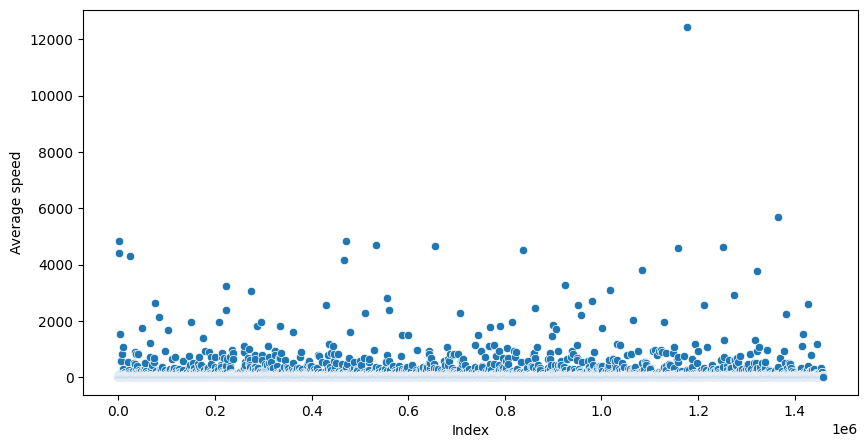

In [27]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [28]:
# Убираем слишком длинные поездки (> 24 часов)
taxi_data = taxi_data[taxi_data['trip_duration'] <= 24*3600]

# Считаем среднюю скорость
taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6  

# Убираем телепортации (> 300 км/ч)
taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]

# Проверим размер выборки
print(f"Оставшееся количество поездок: {taxi_data.shape[0]}")

Оставшееся количество поездок: 1458233


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [29]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

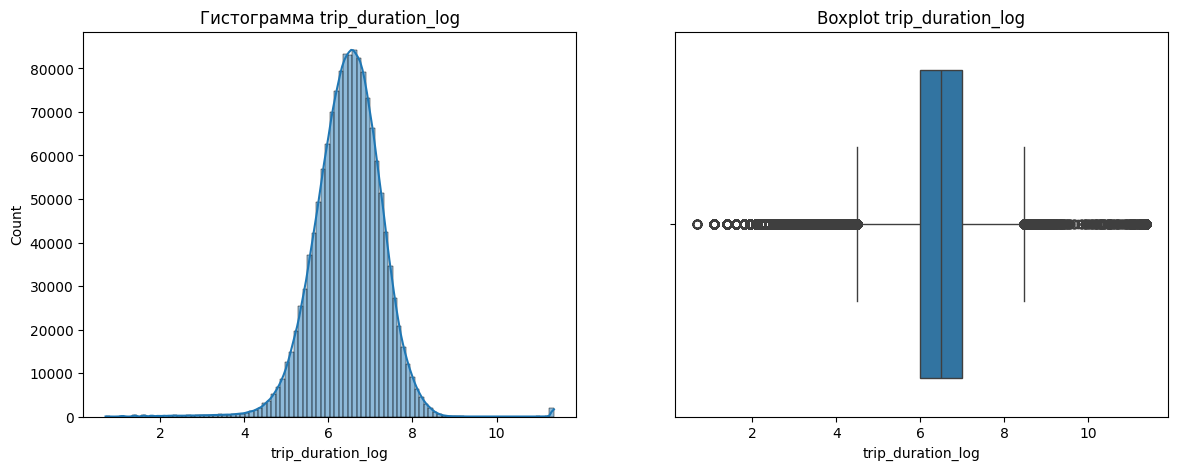

p-value: 0.00
❌ Распределение НЕ является нормальным (отвергаем H0)


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest

# Визуализация
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(taxi_data['trip_duration_log'], bins=100, kde=True, ax=ax[0])
ax[0].set_title('Гистограмма trip_duration_log')

sns.boxplot(x=taxi_data['trip_duration_log'], ax=ax[1])
ax[1].set_title('Boxplot trip_duration_log')

plt.show()

# Тест Д'Агостино
stat, p_value = normaltest(taxi_data['trip_duration_log'].dropna())

print(f"p-value: {p_value:.2f}")

if p_value < 0.05:
    print("❌ Распределение НЕ является нормальным (отвергаем H0)")
else:
    print("✅ Нет оснований отвергнуть H0: распределение похоже на нормальное")

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

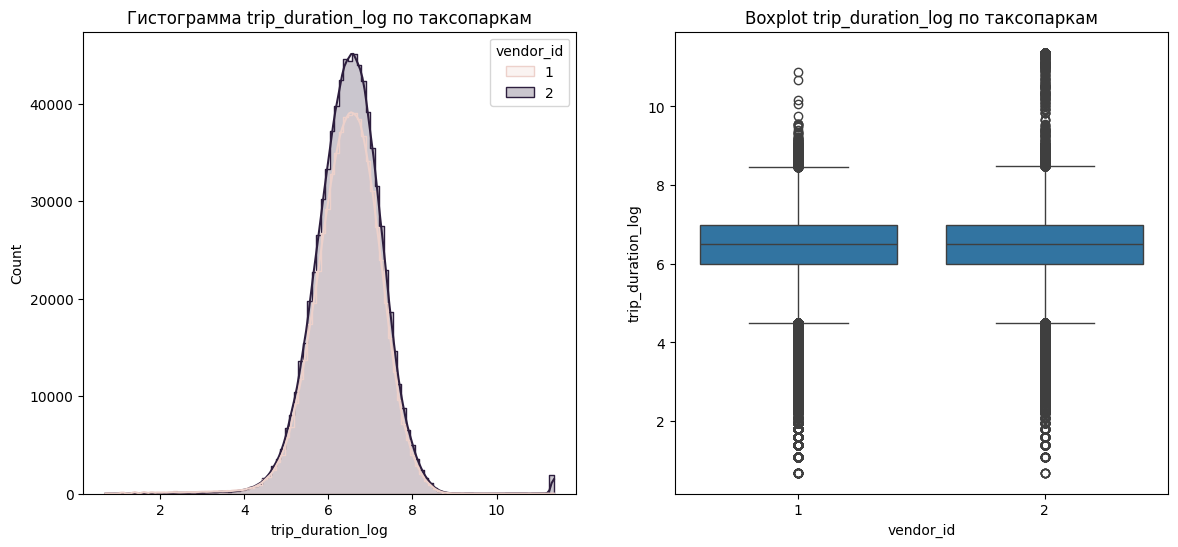

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма с наложением
sns.histplot(data=taxi_data, x="trip_duration_log", hue="vendor_id",
             bins=100, kde=True, ax=ax[0], element="step")
ax[0].set_title("Гистограмма trip_duration_log по таксопаркам")

# Boxplot
sns.boxplot(data=taxi_data, x="vendor_id", y="trip_duration_log", ax=ax[1])
ax[1].set_title("Boxplot trip_duration_log по таксопаркам")

plt.show()

### Выводы по графикам распределения `trip_duration_log` в зависимости от `vendor_id`

1. **Гистограмма** показывает, что распределения длительности поездок в логарифмическом масштабе для обоих таксопарков (`vendor_id = 1` и `vendor_id = 2`) практически совпадают. Оба имеют близкую форму и центрированы примерно в одном диапазоне (около 6–7).  
   - Это говорит о том, что распределение поездок в целом не зависит от таксопарка.  

2. **Boxplot** подтверждает наблюдения с гистограммы: медианы у двух выборок очень близки друг к другу, что говорит об одинаковых "типичных" значениях длительности поездок.  
   - Межквартильные размахи (IQR) также почти одинаковы.  
   - Отличие заключается в большем количестве выбросов у `vendor_id = 2`, особенно в сторону длинных поездок (правый хвост).  

3. Таким образом, можно заключить:  
   - Распределения очень похожи, но таксопарк с `vendor_id = 2` имеет больше длинных поездок (выбросов), чем `vendor_id = 1`.  
   - Это может указывать на различия в клиентской базе или маршрутах таксопарков, но в целом основная масса поездок одинакова.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

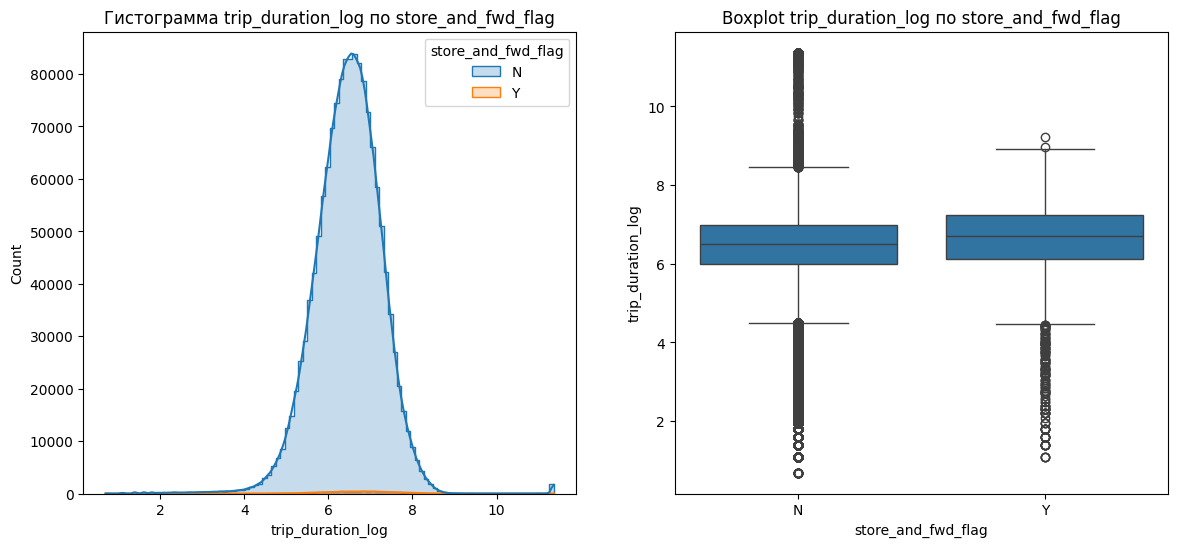

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма
sns.histplot(data=taxi_data, x="trip_duration_log", hue="store_and_fwd_flag",
             bins=100, kde=True, ax=ax[0], element="step")
ax[0].set_title("Гистограмма trip_duration_log по store_and_fwd_flag")

# Boxplot
sns.boxplot(data=taxi_data, x="store_and_fwd_flag", y="trip_duration_log", ax=ax[1])
ax[1].set_title("Boxplot trip_duration_log по store_and_fwd_flag")

plt.show()

### Выводы по графикам распределения `trip_duration_log` в зависимости от признака `store_and_fwd_flag`

1. **Гистограмма** показывает, что подавляющее большинство поездок имеют значение `store_and_fwd_flag = N` (сообщение не сохранялось перед отправкой).  
   - Доля поездок с `store_and_fwd_flag = Y` крайне мала, поэтому их распределение практически не заметно на фоне основной массы.  

2. **Boxplot** подтверждает эту диспропорцию:  
   - Для обеих категорий медиана и межквартильный размах очень похожи.  
   - Наблюдаются выбросы как для `N`, так и для `Y`, но их количество в категории `Y` значительно меньше из-за редкости таких поездок.  

3. Основные выводы:  
   - Признак `store_and_fwd_flag` не оказывает значимого влияния на распределение длительности поездок.  
   - Различия в распределениях несущественны, а дисбаланс классов говорит о том, что поездки с `Y` можно считать редким случаем.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

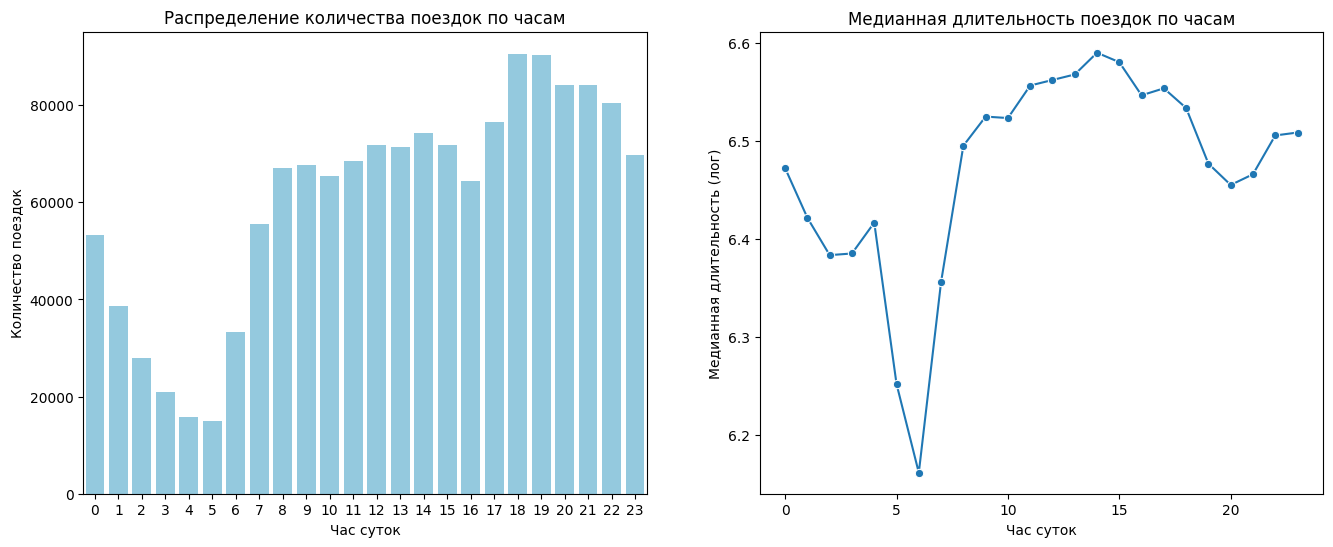

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Количество поездок по часам
sns.countplot(data=taxi_data, x="pickup_hour", ax=ax[0], color="skyblue")
ax[0].set_title("Распределение количества поездок по часам")
ax[0].set_xlabel("Час суток")
ax[0].set_ylabel("Количество поездок")

# 2. Медианная длительность поездки по часам
median_duration = taxi_data.groupby("pickup_hour")["trip_duration_log"].median().reset_index()
sns.lineplot(data=median_duration, x="pickup_hour", y="trip_duration_log", marker="o", ax=ax[1])
ax[1].set_title("Медианная длительность поездок по часам")
ax[1].set_xlabel("Час суток")
ax[1].set_ylabel("Медианная длительность (лог)")

plt.show()

### Ответы на задание 3.4

**а) В какое время суток такси заказывают реже всего?**  
Такси заказывают реже всего в **5–6 часов утра**, когда наблюдается минимальное количество поездок.  

**б) В какое время суток наблюдается пик медианной длительности поездок?**  
Пик медианной длительности поездок (в логарифмическом масштабе) наблюдается **в районе 14–15 часов дня**, что может быть связано с дневными пробками и повышенной загруженностью дорог.  

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


C:\Users\user\AppData\Local\Temp\ipykernel_15756\2103828926.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="day_of_week", data=taxi_data, ax=ax[0], palette="Blues")


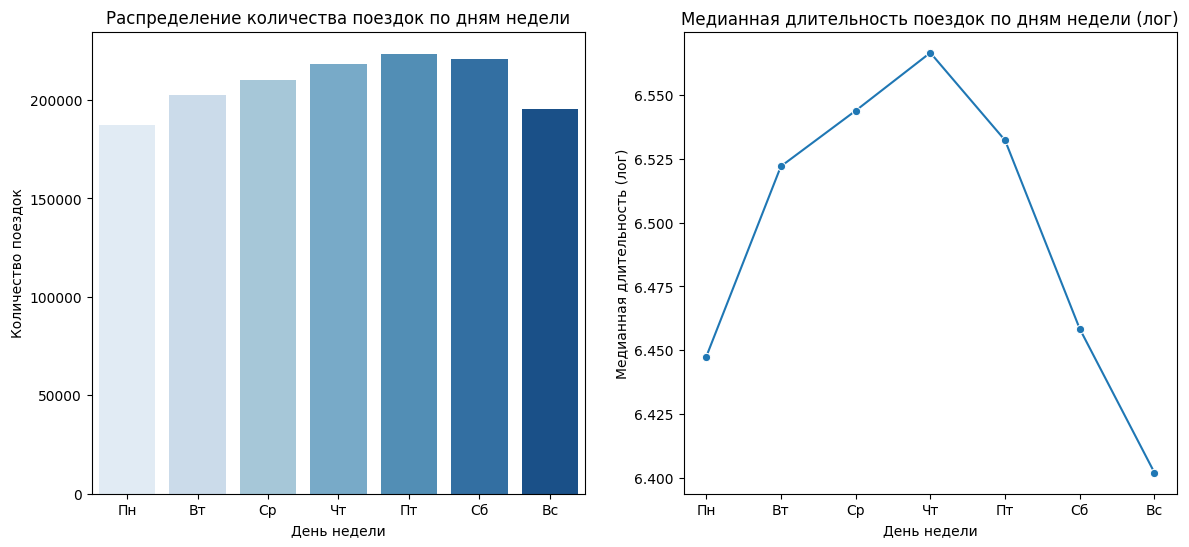

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Добавим колонку с днем недели (0 - понедельник, 6 - воскресенье)
taxi_data["day_of_week"] = taxi_data["pickup_datetime"].dt.dayofweek

# Названия дней недели для наглядности
days = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Количество поездок по дням недели
sns.countplot(x="day_of_week", data=taxi_data, ax=ax[0], palette="Blues")
ax[0].set_xticks(range(7))
ax[0].set_xticklabels(days)
ax[0].set_title("Распределение количества поездок по дням недели")
ax[0].set_xlabel("День недели")
ax[0].set_ylabel("Количество поездок")

# 2. Медианная длительность поездок по дням недели
median_duration = taxi_data.groupby("day_of_week")["trip_duration_log"].median().reset_index()
sns.lineplot(x="day_of_week", y="trip_duration_log", data=median_duration, marker="o", ax=ax[1])
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(days)
ax[1].set_title("Медианная длительность поездок по дням недели (лог)")
ax[1].set_xlabel("День недели")
ax[1].set_ylabel("Медианная длительность (лог)")

plt.show()

📊 Выводы по графикам

а) В какой день недели совершается больше всего поездок?
👉 Больше всего поездок совершается в пятницу (Пт).

б) В какой день недели медианная длительность поездок наименьшая?
👉 Наименьшая медианная длительность поездок наблюдается в воскресенье (Вс)

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

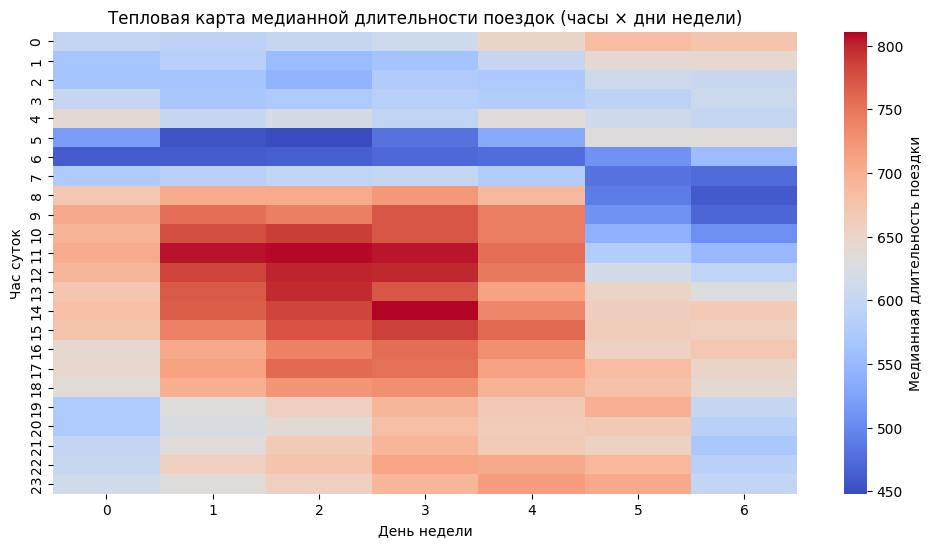

In [35]:
# Построение сводной таблицы
pivot_table = taxi_data.pivot_table(
    index="pickup_hour", 
    columns="pickup_day_of_week", 
    values="trip_duration", 
    aggfunc="median"
)

# Визуализация тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=False, cbar_kws={'label': 'Медианная длительность поездки'})
plt.title("Тепловая карта медианной длительности поездок (часы × дни недели)")
plt.xlabel("День недели")
plt.ylabel("Час суток")
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


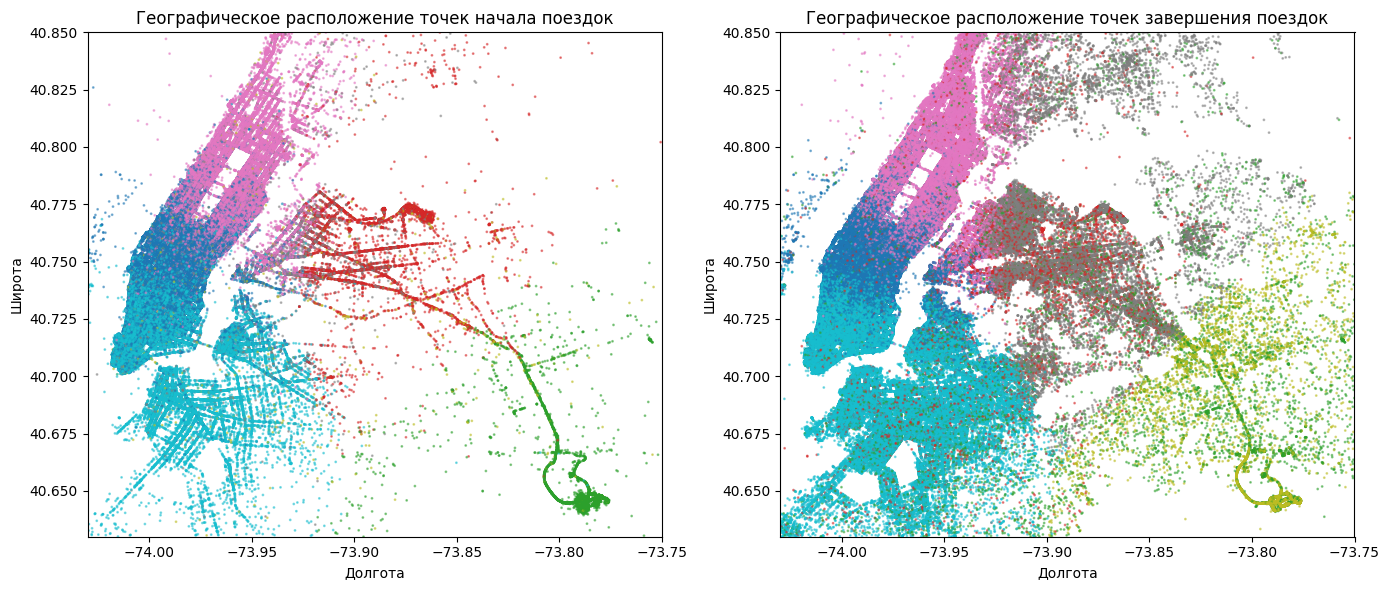

In [36]:
# Границы города Нью-Йорк
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Фильтрация данных по границам города
pickup_points = taxi_data[
    (taxi_data["pickup_longitude"].between(city_long_border[0], city_long_border[1])) &
    (taxi_data["pickup_latitude"].between(city_lat_border[0], city_lat_border[1]))
]

dropoff_points = taxi_data[
    (taxi_data["dropoff_longitude"].between(city_long_border[0], city_long_border[1])) &
    (taxi_data["dropoff_latitude"].between(city_lat_border[0], city_lat_border[1]))
]

# Построение scatter-диаграмм
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pickup точки
ax[0].scatter(
    pickup_points["pickup_longitude"], 
    pickup_points["pickup_latitude"], 
    c=pickup_points["geo_cluster"], 
    cmap="tab10", 
    s=1, alpha=0.5
)
ax[0].set_title("Географическое расположение точек начала поездок")
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
ax[0].set_xlabel("Долгота")
ax[0].set_ylabel("Широта")

# Dropoff точки
ax[1].scatter(
    dropoff_points["dropoff_longitude"], 
    dropoff_points["dropoff_latitude"], 
    c=dropoff_points["geo_cluster"], 
    cmap="tab10", 
    s=1, alpha=0.5
)
ax[1].set_title("Географическое расположение точек завершения поездок")
ax[1].set_xlim(city_long_border)
ax[1].set_ylim(city_lat_border)
ax[1].set_xlabel("Долгота")
ax[1].set_ylabel("Широта")

plt.tight_layout()
plt.show()

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [43]:
# Явно укажем только те колонки, которые нужны (как в правильном варианте)
needed_columns = [
    'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
    'passenger_count', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
    'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
    'pickup_holiday', 'total_distance', 'total_travel_time',
    'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
    'temperature', 'visibility', 'wind_speed', 'precip', 'events',
    'trip_duration_log'
]

# Оставляем только эти столбцы
taxi_data = taxi_data[needed_columns]

print('Shape of data:', taxi_data.shape)
print('Columns:', taxi_data.columns)

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind_speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [44]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind_speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [45]:
# Убираем неинформативные и "утекающие" признаки
taxi_data = taxi_data.drop(columns=['id', 'trip_duration', 'trip_duration_log'])

print("Shape of data:", taxi_data.shape)
print("Columns:", taxi_data.columns)

Shape of data: (1458233, 24)
Columns: Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'geo_cluster', 'temperature', 'visibility', 'wind_speed',
       'precip', 'events'],
      dtype='object')


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [46]:
# Удаляем неинформативные и создающие утечку признаки
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

# Проверяем размерность
print('Shape of train_data:', train_data.shape)
print('Columns:', train_data.columns)

Shape of train_data: (1458233, 25)
Columns: Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'geo_cluster', 'temperature', 'visibility', 'wind_speed',
       'precip', 'events', 'trip_duration_log'],
      dtype='object')


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [47]:
# Кодируем vendor_id
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

# Кодируем store_and_fwd_flag
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# Считаем среднее
vendor_mean = round(train_data['vendor_id'].mean(), 2)
store_mean = round(train_data['store_and_fwd_flag'].mean(), 3)

print("Среднее по vendor_id:", vendor_mean)
print("Среднее по store_and_fwd_flag:", store_mean)

Среднее по vendor_id: 0.53
Среднее по store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [48]:
from sklearn.preprocessing import OneHotEncoder

# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Обучаем и трансформируем данные
data_onehot = one_hot_encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()

# Получаем имена новых закодированных столбцов
column_names = one_hot_encoder.get_feature_names_out(['pickup_day_of_week', 'geo_cluster', 'events'])

# Преобразуем в DataFrame
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

# Проверим результат
print("Размерность data_onehot:", data_onehot.shape)
print("Количество бинарных столбцов:", data_onehot.shape[1])

Размерность data_onehot: (1458233, 18)
Количество бинарных столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [50]:
# Указываем, какие колонки будем заменять
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# Объединяем train_data без старых колонок + onehot
train_data = pd.concat(
    [
        train_data.drop(columns=columns_to_change).reset_index(drop=True),
        data_onehot.reset_index(drop=True)
    ],
    axis=1
)

print('Shape of data:', train_data.shape)
print('Columns:', train_data.columns)

Shape of data: (1458233, 40)
Columns: Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_hour',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'temperature',
       'visibility', 'wind_speed', 'precip', 'trip_duration_log',
       'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'geo_cluster_1', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4',
       'geo_cluster_5', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8',
       'geo_cluster_9', 'events_None', 'events_Rain', 'events_Snow'],
      dtype='object')


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [51]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [52]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [55]:
# признаки, которые убираем
non_numeric_features = ['pickup_datetime', 'pickup_date', 'pickup_hour']

# удаляем их из обучающей и валидационной выборок
X_train_num = X_train.drop(columns=non_numeric_features)
X_valid_num = X_valid.drop(columns=non_numeric_features)

# создаём селектор
selector = SelectKBest(score_func=f_regression, k=25)

# обучаем селектор на числовых данных
selector.fit(X_train_num, y_train_log)

# получаем имена отобранных признаков
selected_features = X_train_num.columns[selector.get_support()]
print("Отобранные признаки:", selected_features.tolist())

Отобранные признаки: ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'temperature', 'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [57]:
from sklearn.preprocessing import MinMaxScaler

# создаём нормализатор
scaler = MinMaxScaler()

# обучаем на тренировочной выборке и трансформируем обе
X_train_scaled = scaler.fit_transform(X_train_num)
X_valid_scaled = scaler.transform(X_valid_num)

# считаем среднее значение по первому предиктору в валидационной выборке
mean_first_feature = np.mean(X_valid_scaled[:, 0])

print("Среднее значение первого предиктора (валидация): {:.2f}".format(mean_first_feature))

Среднее значение первого предиктора (валидация): 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Обучаем модель линейной регрессии
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train_log)

# Делаем предсказания
y_train_pred = linreg.predict(X_train_scaled)
y_valid_pred = linreg.predict(X_valid_scaled)

# Считаем RMSLE через RMSE (так как целевая переменная уже в логарифме)
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

print(f'RMSLE на обучающей выборке: {rmsle_train:.2f}')
print(f'RMSLE на валидационной выборке: {rmsle_valid:.2f}')

RMSLE на обучающей выборке: 0.53
RMSLE на валидационной выборке: 0.53


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [59]:
from sklearn.preprocessing import PolynomialFeatures

# Генерация полиномиальных признаков 2-й степени
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

print(f'Размер обучающей выборки: {X_train_poly.shape}')
print(f'Размер валидационной выборки: {X_valid_poly.shape}')

# Обучаем линейную регрессию на полиномиальных признаках
linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train_log)

# Предсказания
y_train_poly_pred = linreg_poly.predict(X_train_poly)
y_valid_poly_pred = linreg_poly.predict(X_valid_poly)

# Считаем RMSLE через RMSE (так как целевая переменная логарифмирована)
rmsle_train_poly = np.sqrt(mean_squared_error(y_train_log, y_train_poly_pred))
rmsle_valid_poly = np.sqrt(mean_squared_error(y_valid_log, y_valid_poly_pred))

print(f'RMSLE (train, poly): {rmsle_train_poly:.2f}')
print(f'RMSLE (valid, poly): {rmsle_valid_poly:.2f}')

Размер обучающей выборки: (977016, 665)
Размер валидационной выборки: (481217, 665)
RMSLE (train, poly): 0.47
RMSLE (valid, poly): 0.61


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [60]:
from sklearn.linear_model import Ridge

# Создаём модель Ridge с α=1
ridge_poly = Ridge(alpha=1)

# Обучаем модель на полиномиальных признаках
ridge_poly.fit(X_train_poly, y_train_log)

# Предсказания
y_train_ridge_pred = ridge_poly.predict(X_train_poly)
y_valid_ridge_pred = ridge_poly.predict(X_valid_poly)

# RMSLE через RMSE (так как целевая переменная логарифмирована)
rmsle_train_ridge = np.sqrt(mean_squared_error(y_train_log, y_train_ridge_pred))
rmsle_valid_ridge = np.sqrt(mean_squared_error(y_valid_log, y_valid_ridge_pred))

print(f'RMSLE (train, ridge poly): {rmsle_train_ridge:.2f}')
print(f'RMSLE (valid, ridge poly): {rmsle_valid_ridge:.2f}')

RMSLE (train, ridge poly): 0.49
RMSLE (valid, ridge poly): 0.49


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [61]:
from sklearn.tree import DecisionTreeRegressor

# Создаём модель дерева решений
tree = DecisionTreeRegressor(random_state=42)

# Обучаем на тренировочных данных
tree.fit(X_train_scaled, y_train_log)

# Предсказания
y_train_tree_pred = tree.predict(X_train_scaled)
y_valid_tree_pred = tree.predict(X_valid_scaled)

# RMSLE (через RMSE, так как y у нас уже логарифмирован)
rmsle_train_tree = np.sqrt(mean_squared_error(y_train_log, y_train_tree_pred))
rmsle_valid_tree = np.sqrt(mean_squared_error(y_valid_log, y_valid_tree_pred))

print(f'RMSLE (train, tree): {rmsle_train_tree:.2f}')
print(f'RMSLE (valid, tree): {rmsle_valid_tree:.2f}')

RMSLE (train, tree): 0.00
RMSLE (valid, tree): 0.61


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


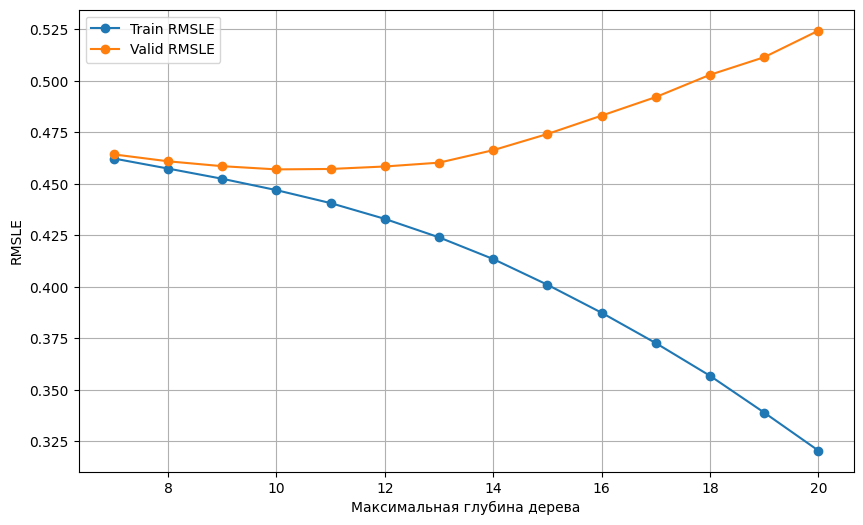

Оптимальная глубина дерева: 10
RMSLE (train): 0.45
RMSLE (valid): 0.46


In [62]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Диапазон глубин
max_depths = range(7, 21)

rmsle_train = []
rmsle_valid = []

# Перебираем все глубины
for d in max_depths:
    tree = DecisionTreeRegressor(max_depth=d, random_state=42)
    tree.fit(X_train_scaled, y_train_log)

    y_train_pred = tree.predict(X_train_scaled)
    y_valid_pred = tree.predict(X_valid_scaled)

    rmsle_train.append(np.sqrt(mean_squared_error(y_train_log, y_train_pred)))
    rmsle_valid.append(np.sqrt(mean_squared_error(y_valid_log, y_valid_pred)))

# Графики
plt.figure(figsize=(10,6))
plt.plot(max_depths, rmsle_train, marker='o', label='Train RMSLE')
plt.plot(max_depths, rmsle_valid, marker='o', label='Valid RMSLE')
plt.xlabel("Максимальная глубина дерева")
plt.ylabel("RMSLE")
plt.legend()
plt.grid(True)
plt.show()

# Оптимальная глубина (где RMSLE на валидации минимально)
optimal_depth = max_depths[np.argmin(rmsle_valid)]
print(f"Оптимальная глубина дерева: {optimal_depth}")
print(f"RMSLE (train): {rmsle_train[np.argmin(rmsle_valid)]:.2f}")
print(f"RMSLE (valid): {rmsle_valid[np.argmin(rmsle_valid)]:.2f}")

# 🎯 Общий вывод

- **Линейная регрессия (5.1)**  
  Даёт устойчивый, но не лучший результат.

- **Полиномиальная регрессия (5.2)**  
  Улучшает обучение на train, но страдает от переобучения.

- **Полиномиальная регрессия с регуляризацией Ridge (5.3)**  
  Отлично решает проблему переобучения, повышая устойчивость и качество.

- **Дерево решений без ограничений (5.4)**  
  Полностью переобучается (нулевая ошибка на train, высокая на valid).

- **Подбор глубины дерева (5.5)**  
  Показывает, что деревья при правильной настройке могут дать лучшее качество  
  (RMSLE ≈ 0.45–0.46), лучше, чем линейные модели.

---

✅ **Лучшая модель — дерево решений с оптимальной глубиной (10).**  
Оно даёт наименьшую ошибку и хорошо сбалансировано между обучающей и валидационной выборками.

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Создаём модель случайного леса
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42
)

# Обучаем модель
rf.fit(X_train_scaled, y_train_log)

# Предсказания
y_train_rf_pred = rf.predict(X_train_scaled)
y_valid_rf_pred = rf.predict(X_valid_scaled)

# Считаем RMSLE через RMSE (целевая переменная в логарифме)
rmsle_train_rf = np.sqrt(mean_squared_error(y_train_log, y_train_rf_pred))
rmsle_valid_rf = np.sqrt(mean_squared_error(y_valid_log, y_valid_rf_pred))

print(f'RMSLE (train, RF): {rmsle_train_rf:.2f}')
print(f'RMSLE (valid, RF): {rmsle_valid_rf:.2f}')

RMSLE (train, RF): 0.43
RMSLE (valid, RF): 0.44


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [64]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Создаём модель градиентного бустинга
gboost = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)

# Обучаем модель
gboost.fit(X_train_scaled, y_train_log)

# Предсказания
y_train_gb_pred = gboost.predict(X_train_scaled)
y_valid_gb_pred = gboost.predict(X_valid_scaled)

# RMSLE (через RMSE, так как y уже в логарифме)
rmsle_train_gb = np.sqrt(mean_squared_error(y_train_log, y_train_gb_pred))
rmsle_valid_gb = np.sqrt(mean_squared_error(y_valid_log, y_valid_gb_pred))

print(f'RMSLE (train, Gradient Boosting): {rmsle_train_gb:.2f}')
print(f'RMSLE (valid, Gradient Boosting): {rmsle_valid_gb:.2f}')

RMSLE (train, Gradient Boosting): 0.40
RMSLE (valid, Gradient Boosting): 0.42


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решени

Наилучший результат (наименьшее значение RMSLE на валидационной выборке) показала модель градиентного бустинга над деревьями решений:

👉 RMSLE (valid) = 0.42

Она лучше, чем случайный лес (0.44) и значительно опережает линейные/полиномиальные модели и одиночное дерево.

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


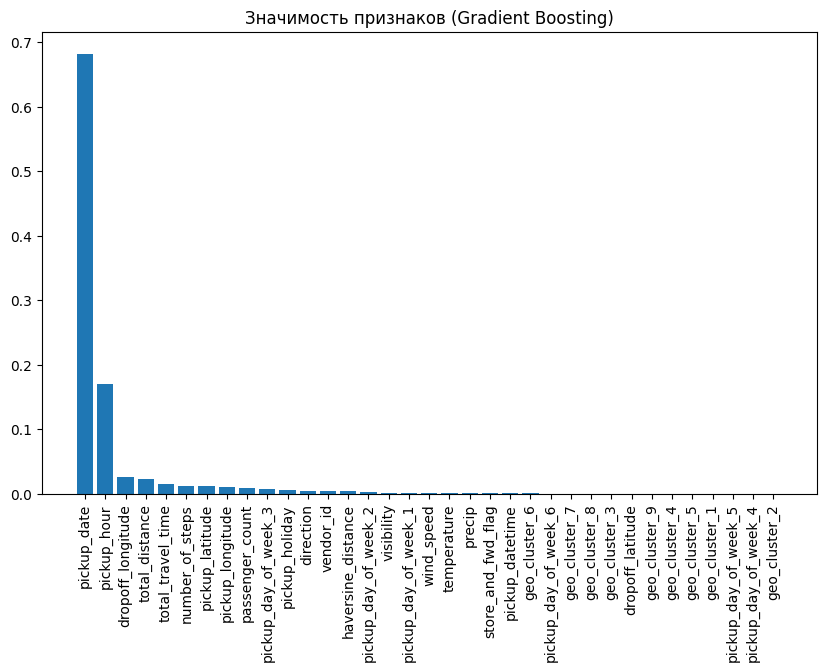

Топ-3 наиболее значимых признака: ['pickup_date' 'pickup_hour' 'dropoff_longitude']


In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Важности признаков
importances = gboost.feature_importances_

# Берём имена признаков из исходного DataFrame (до StandardScaler)
feature_names = X_train.columns  

# Сортируем по значимости
indices = np.argsort(importances)[::-1]

# Строим график
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.title("Значимость признаков (Gradient Boosting)")
plt.show()

# Топ-3 признака
top3 = np.array(feature_names)[indices[:3]]
print("Топ-3 наиболее значимых признака:", top3)

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [68]:
from sklearn.metrics import median_absolute_error

# Предсказания на валидации (в логарифмах)
y_valid_pred_log = gboost.predict(X_valid_scaled)

# Переводим обратно из логарифма в исходные значения (секунды)
y_valid_pred = np.expm1(y_valid_pred_log)
y_valid_true = np.expm1(y_valid_log)

# Считаем медианную абсолютную ошибку
meae_seconds = median_absolute_error(y_valid_true, y_valid_pred)

# Переводим в минуты
meae_minutes = meae_seconds / 60

print(f"MeAE (valid): {meae_minutes:.1f} минут")

MeAE (valid): 2.1 минут
